In [1]:
#!pip install torch

In [2]:
#!pip install matplotlib

In [3]:
#!pip install torchvision

In [1]:
import torch
import torch.nn.functional as F
import torchvision
from torch import optim
from torch import nn
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_grayscale

import matplotlib.pyplot as plt
import numpy as np


def execute (runnable):
    if torch.cuda.device_count()>0:
        print ("  --> Let's work with cuda")
        device = torch.device("cuda:0")
        if runnable is not None:
            with torch.cuda.device(0):
                return runnable(device)
        return device
    else:
        print ("  --> Let's work with CPU")
        device = torch.device("cpu")
        if runnable is not None:
            return runnable(device)
        return device


In [2]:

IMG_SIZE = 32
COLOR_CHANNELS = 1

class CutCifar(torch.utils.data.Dataset):

    def __init__(self, cifar_dataset, from_cnt=0, to_cnt=1000):
        self.cifar_dataset = cifar_dataset
        self.from_cnt = from_cnt
        self.to_cnt = to_cnt

    def __len__(self):
        # TODO: Let's assert the negative values
        return self.to_cnt - self.from_cnt

    def __getitem__(self, idx):
        biased_index = self.from_cnt+idx
        image, label = self.cifar_dataset[biased_index]
        if COLOR_CHANNELS == 1:
            image = to_grayscale(img=image, num_output_channels=1)
            image = transforms.ToTensor()(image)
            image = image/image.max()
            image = image.view(IMG_SIZE * IMG_SIZE)
        else :
            image = transforms.ToTensor()(image)
            image = image.view(IMG_SIZE * IMG_SIZE * COLOR_CHANNELS)
        return image, label


# It' used in in loading stage. However it's quite attractive approach connected
# finite transformation pipe
# trans_actions = transforms.Compose([transforms.Resize(img_size + 2),
#                                     transforms.RandomCrop(img_size, padding=2),
#                                     transforms.ToTensor()])



In [3]:
# https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html
# https://www.cs.toronto.edu/~kriz/cifar.html

train_dataset = torchvision.datasets.CIFAR10(root='cifar10/', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='cifar10_test/', train=False, download=True)

TRAIN_SIZE = 30000
train_set = CutCifar(train_dataset,0,TRAIN_SIZE)

TEST_SIZE = 1000
test_set = CutCifar(test_dataset,0,TEST_SIZE)


Files already downloaded and verified
Files already downloaded and verified


torch.Size([1000, 1024])
label is truck


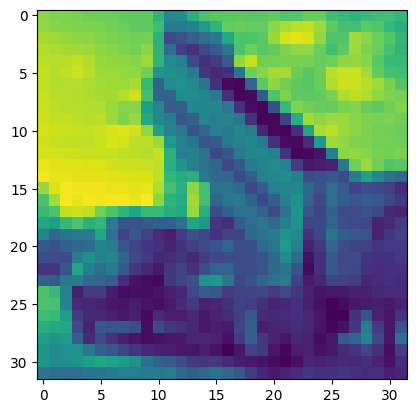

In [4]:
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=TEST_SIZE,shuffle=False,num_workers=0)

classes = ['plane', 'car', 'bird', 'cat','deer', 'dog',
           'frog', 'horse', 'ship', 'truck']

number=50
for batch, label in test_set_loader:
    print(batch.shape)
    plt.imshow(batch[number].view(COLOR_CHANNELS, IMG_SIZE, IMG_SIZE).permute(1, 2, 0))
    print('label is', classes[label[number]])
    break

In [11]:


class Perceptron(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, hidden_layer_quantity, batch_norm_enabled=True):
        
        super().__init__()
        self.layers = []
        
        # Making the basic perceptron:---------------------------------
        dropout_base = 0.05
        self.layers.append(nn.Linear(input_size,hidden_size))
        self.layers.append(nn.Dropout( dropout_base ))
        
        for cnt in range(0,hidden_layer_quantity):
            self.layers.append(nn.Linear(hidden_size,hidden_size))
            if batch_norm_enabled == True:
                self.layers.append(nn.BatchNorm1d(hidden_size))
            drop_coef = (1.0/hidden_layer_quantity) * cnt + 2*dropout_base
            drop_coef = 0.80 if drop_coef>0.80 else drop_coef
            self.layers.append(nn.Dropout( drop_coef ))
        self.layers.append(nn.Linear(hidden_size,output_size))

        # Registering modules for torch:-------------------------------
        for cnt,layer in enumerate(self.layers):
            key = "layer{}".format(cnt)
            self.add_module(key,layer)

    def forward(self, xtr):
        for cnt,layer in enumerate(self.layers):
            if cnt<len(self.layers)-1:
                xtr = F.leaky_relu(layer(xtr))
            else :
                xtr = F.sigmoid(layer(xtr))
        return xtr
    
    def predict_by_softmax(self, x):
        #print("x= ",x.shape)
        xtr = self.forward(x)
        #print("xtr= ",xtr)
        xtr = nn.Softmax(dim=1)(xtr)
        #print("sm xtr= ",xtr)
        values,indexes = torch.max(xtr, 1)
        #print("mx xtr= ",indexes)
        return indexes


In [12]:
# Making neural network and SETTING the DEVICE:----------------------------------------

# 5 layers, 30000 train vectors, 454/1000 test resul accuracy
# perceptron = Perceptron(IMG_SIZE*IMG_SIZE*COLOR_CHANNELS,900,len(classes),3).to(execute(None))
perceptron = Perceptron(IMG_SIZE*IMG_SIZE*COLOR_CHANNELS,700,len(classes),4).to(execute(None))

for idx, module in enumerate(perceptron.modules()):
     print(idx, '->', module)

criteria = nn.MSELoss()
optimizer = optim.SGD(perceptron.parameters(), lr=0.01, momentum=0.05)
#optimizer = optim.RMSprop(perceptron.parameters(), lr=0.05, momentum=0.01)
#optimizer = optim.Adam(perceptron.parameters(), lr=0.05)


  --> Let's work with cuda
0 -> Perceptron(
  (layer0): Linear(in_features=1024, out_features=700, bias=True)
  (layer1): Dropout(p=0.05, inplace=False)
  (layer2): Linear(in_features=700, out_features=700, bias=True)
  (layer3): BatchNorm1d(700, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Dropout(p=0.1, inplace=False)
  (layer5): Linear(in_features=700, out_features=700, bias=True)
  (layer6): BatchNorm1d(700, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer7): Dropout(p=0.35, inplace=False)
  (layer8): Linear(in_features=700, out_features=700, bias=True)
  (layer9): BatchNorm1d(700, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer10): Dropout(p=0.6, inplace=False)
  (layer11): Linear(in_features=700, out_features=700, bias=True)
  (layer12): BatchNorm1d(700, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer13): Dropout(p=0.8, inplace=False)
  (layer14): Linear(in_features=700, out_f

In [13]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def load_to_device(loader,device):
    load_list=[]
    for i, data in enumerate(loader):
        load_list.append((to_device(data[0],device), to_device(data[1],device)))
    return load_list
    

In [14]:
BATCH_SIZE = int(TRAIN_SIZE/10)

train_set_loader = torch.utils.data.DataLoader(
        train_set,batch_size=BATCH_SIZE,shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
        test_set, batch_size=TEST_SIZE,shuffle=True)

data_dev = execute(None)
train_list = load_to_device(train_set_loader,data_dev)
test_list = load_to_device(test_set_loader,data_dev)


  --> Let's work with cuda


In [15]:
# https://discuss.pytorch.org/t/error-while-multiprocessing-in-dataloader/46845/11
# from tqdm.notebook import trange, tqdm

def adapt_perceptron (device):
    epoch_max_num = 50000
    history=[]
    max_test_tp=0
    for epoch_num in range(epoch_max_num):
        running_loss = 0.0
        for train_batch in train_list:
            x_train, y_train = train_batch[0], train_batch[1]
            y_train = F.one_hot(num_classes=10,input=y_train).float();
            y_train[y_train==1.0]=0.75
            optimizer.zero_grad()
            y_pred = perceptron(x_train)
            loss = criteria(y_pred, y_train)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        test_tp=0
        test_overall=0
        y_stat = torch.zeros ((len(test_list),TEST_SIZE),device=device).long()
        y_stat[y_stat==0]=-1
        for j,data in enumerate(test_list):
            x_test, y_test = data[0], data[1]
            y_pred = perceptron.predict_by_softmax(x_test)
            test_overall += len(y_test)
            test_tp += (y_test == y_pred).sum()
            xtr = y_test!=y_pred
            y_stat[j,xtr]=y_test[xtr]

        history.append((epoch_num,test_tp,running_loss))
        if epoch_num % 100==0 or max_test_tp<test_tp:
            if max_test_tp<test_tp:
                max_test_tp=test_tp
                torch.save(perceptron.state_dict(), "model-{}.torch".format(test_tp))
                print ("  >> Saved: {}".format(test_tp))
                
            print("Epoch [{}/{}] loss: {} TP={} Overall={} max={}".format(epoch_num,epoch_max_num,
                                                                          running_loss,test_tp,
                                                                          test_overall,max_test_tp))
            (class_nums,failures)=torch.unique(input=y_stat[y_stat>=0],sorted=True,return_counts=True)
            print("  >> NR: ",class_nums,failures)
            
    print('Adapting is finished!')
    return history

train_history = execute(runnable=adapt_perceptron)


  --> Let's work with cuda
  >> Saved: 119
Epoch [0/50000] loss: 2.6561314463615417 TP=119 Overall=1000 max=119
  >> NR:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0') tensor([ 93,  64,  92,  87,  81,  83, 100,  89,  95,  97], device='cuda:0')
  >> Saved: 134
Epoch [19/50000] loss: 1.057431474328041 TP=134 Overall=1000 max=134
  >> NR:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0') tensor([85, 76, 87, 92, 81, 78, 97, 82, 91, 97], device='cuda:0')
Epoch [100/50000] loss: 0.6178101226687431 TP=89 Overall=1000 max=134
  >> NR:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0') tensor([ 96,  80,  97,  98,  81,  81,  97,  92,  86, 103], device='cuda:0')
Epoch [200/50000] loss: 0.5708973780274391 TP=92 Overall=1000 max=134
  >> NR:  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0') tensor([98, 81, 91, 95, 84, 77, 99, 93, 93, 97], device='cuda:0')
  >> Saved: 143
Epoch [260/50000] loss: 0.5601293258368969 TP=143 Overall=1000 max=143
  >> NR:  tensor([0, 1, 2, 3

In [53]:
# SGD LOSS -> 0.032
# RMSprop -> 0.24


In [1]:
epoch_list=[]
tp_list=[]
mse_list=[]
for (num,tp,mse) in train_history:
    epoch_list.append(num)
    tp_list.append(tp.to(device='cpu').item())
    mse_list.append(mse)

plt.plot(epoch_list,tp_list)
plt.show()
plt.plot(epoch_list,mse_list)

NameError: name 'train_history' is not defined